In [ ]:
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops transformers
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers
!git lfs install
!git clone https://huggingface.co/boris/vqgan_f16_16384

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Total 1335 (delta 0), reused 0 (delta 0), pack-reused 1335
Receiving objects: 100% (1335/1335), 409.77 MiB | 50.01 MiB/s, done.
Resolving deltas: 100% (277/277), done.
/content/taming-transformers
Updated git hooks.
Git LFS initialized.
Cloning into 'vqgan_f16_16384'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -qq train2014.zip
%rm train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip -qq val2014.zip
%rm val2014.zip

--2022-06-04 17:02:53--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.225.249
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.225.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  63.6MB/s    in 2m 35s  

2022-06-04 17:05:28 (83.0 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2022-06-04 17:07:41--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.153.44
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.153.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  52.6MB/s    in 1m 47s  

2022-06-04 17:09:29 (59.2 MB/s) -

In [ ]:
!mkdir meta
!mkdir outs

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
cp: cannot create regular file '/content/taming_transformers/samples.tar.gz': No such file or directory
tar (child): samples.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
!cp /content/drive/MyDrive/samples.tar.gz ./samples.tar.gz
!tar -zxf ./samples.tar.gz

In [ ]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

# For data loading
import torch
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader
from torchvision.transforms import InterpolationMode

# For data saving
from pathlib import Path
import pandas as pd
from tqdm import tqdm

from taming.models.vqgan import VQModel

In [ ]:
# test_dir = './train_small'
image_dir1 = 'train2014'
image_dir2 = 'val2014'
all_image_list = []
for base in (image_dir1, image_dir2):
    all_image_list.extend([*map(lambda fname: os.path.join(base, fname), os.listdir(base))])
n_images = len(all_image_list)
print(n_images, 'images')
print(all_image_list[:5])
print(all_image_list[-5:])

123287 images
['train2014/COCO_train2014_000000571483.jpg', 'train2014/COCO_train2014_000000190805.jpg', 'train2014/COCO_train2014_000000419750.jpg', 'train2014/COCO_train2014_000000543838.jpg', 'train2014/COCO_train2014_000000252214.jpg']
['val2014/COCO_val2014_000000515727.jpg', 'val2014/COCO_val2014_000000499866.jpg', 'val2014/COCO_val2014_000000197796.jpg', 'val2014/COCO_val2014_000000318193.jpg', 'val2014/COCO_val2014_000000292789.jpg']


In [ ]:
n_split = 5
base_meta_dir = './meta'
image_meta = [os.path.join(base_meta_dir, f'meta{i:02d}.tsv') for i in range(n_split)]
for i in range(n_split):
    st, ed = (n_images*i)//n_split, (n_images*(i+1))//n_split
    sub_images = all_image_list[st:ed]
    print(f'{image_meta[i]}  [{st}:{ed}] len {len(sub_images)}')
    with open(image_meta[i], 'w') as f:
        for image_name in sub_images:
            f.write(image_name+'\n')


./meta/meta00.tsv  [0:24657] len 24657
./meta/meta01.tsv  [24657:49314] len 24657
./meta/meta02.tsv  [49314:73972] len 24658
./meta/meta03.tsv  [73972:98629] len 24657
./meta/meta04.tsv  [98629:123287] len 24658


In [ ]:
sample_dir = 'samples'
sample_meta_dir = './meta/sample_meta.tsv'
with open(sample_meta_dir, 'w') as f:
    for image_name in map(lambda fname: os.path.join(sample_dir, fname), os.listdir(sample_dir)):
        f.write(image_name+'\n')

In [ ]:
from omegaconf import OmegaConf
config_path = "./vqgan_f16_16384/config.yaml"
config = OmegaConf.load(config_path)
import yaml
yaml.dump(OmegaConf.to_container(config))

'model:\n  base_learning_rate: 4.5e-06\n  params:\n    ddconfig:\n      attn_resolutions:\n      - 16\n      ch: 128\n      ch_mult:\n      - 1\n      - 1\n      - 2\n      - 2\n      - 4\n      double_z: false\n      dropout: 0.0\n      in_channels: 3\n      num_res_blocks: 2\n      out_ch: 3\n      resolution: 256\n      z_channels: 256\n    embed_dim: 256\n    lossconfig:\n      params:\n        codebook_weight: 1.0\n        disc_conditional: false\n        disc_in_channels: 3\n        disc_num_layers: 2\n        disc_start: 0\n        disc_weight: 0.75\n      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator\n    n_embed: 16384\n  target: taming.models.vqgan.VQModel\n'

In [ ]:
model = VQModel(**config.model.params)
ckpt_path = "./vqgan_f16_16384/model.ckpt"
sd = torch.load(ckpt_path)["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model = model.cuda()

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
# image_list = 'meta.tsv'
# output_tsv = 'output.tsv'
batch_size = 64
num_workers = 4
img_size = 64

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_list_path: str, image_size: int, max_items=None):
        """
        :param image_list_path: Path to a file containing a list of all images. We assume absolute paths for now.
        :param image_size: Image size. Source images will be resized and center-cropped.
        :max_items: Limit dataset size for debugging
        """
        self.image_list = pd.read_csv(image_list_path, sep='\t', header=None)
        if max_items is not None: self.image_list = self.image_list[:max_items]
        self.image_size = image_size
        
    def __len__(self):
        return len(self.image_list)
    
    def _get_raw_image(self, i):
        image_path = Path(self.image_list.iloc[i][0])
        return default_loader(image_path)
    
    def resize_image(self, image):
        s = min(image.size)
        r = self.image_size / s
        s = (round(r * image.size[1]), round(r * image.size[0]))
        image = TF.resize(image, s, interpolation=InterpolationMode.LANCZOS)
        image = TF.center_crop(image, output_size = 2 * [self.image_size])
        image = (np.array(image, dtype=np.float32) / 127.5) - 1
        # image = np.expand_dims(np.array(image), axis=0)
        return image
    
    def __getitem__(self, i):
        image = self._get_raw_image(i)
        return self.resize_image(image)



def encode_dataset(dataset, batch_size, output_path):
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    
    with open(output_path, "w") as f:
        iterations = len(dataloader)
        model.eval()
        with torch.no_grad():
            for n, x in enumerate(tqdm(dataloader)):
                x = x.cuda()
                x = x.permute([0, 3, 1, 2])
                # print(x.shape)
                # print(x.dtype)
                bs = x.shape[0]
                _, _, (_, _, encoded) = model.encode(x)
                # print(a.shape)
                # print(encoded.shape)
                # break
                encoded = encoded.reshape(bs, -1).cpu().numpy().tolist()

                # Extract paths from the dataset, save paths and encodings (as string)
                start_index = n * batch_size
                end_index = (n+1) * batch_size
                paths = dataset.image_list[start_index:end_index][0].values
                # print(paths)
                # encoded_as_string = list(map(lambda item: np.array2string(item, separator=',', max_line_width=50000, formatter={'int':lambda x: str(x)}), encoded))
                batch_df = pd.DataFrame.from_dict({"image_file": paths, "encoding": encoded})
                batch_df.to_csv(f, sep='\t', header=False, index=None)

In [ ]:
# dataset = ImageDataset(image_list, image_size=256)
# len(dataset)

In [ ]:
# encode_dataset(dataset, batch_size=batch_size)

In [ ]:
datasets = [ImageDataset(img_list, image_size=img_size) for img_list in image_meta]
for i in range(n_split):
    print(i, len(datasets[i]))

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


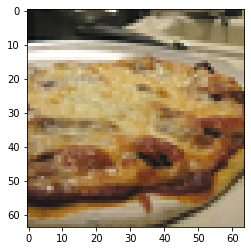

In [ ]:
img_sample = datasets[0][0]
img = ((img_sample + 1) * 127.5).astype(np.int)
plt.imshow(img)

In [ ]:
sample_ds = ImageDataset(sample_meta_dir, image_size=img_size)

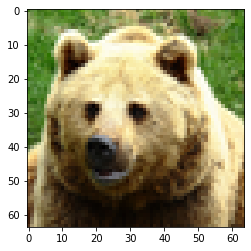

In [ ]:
img_sample = sample_ds[33]
img = ((img_sample + 1) * 127.5).astype(int)
plt.imshow(img)

In [ ]:
sample_tensor = torch.from_numpy(np.expand_dims(img_sample.transpose([2, 0, 1]), axis=0)).cuda()
print(sample_tensor.size())
sample_quant, _, (_, _, code_sample) = model.encode(sample_tensor)
print(code_sample.size())
print(sample_quant.size())

torch.Size([1, 3, 64, 64])
torch.Size([16])
torch.Size([1, 256, 4, 4])


In [1]:
code_from_quant = model.quantize.get_codebook_entry(code_sample, [-1, img_size//16, img_size//16, 256])
code_from_quant.size()
dec = model.decode(code_from_quant)
dec.size()
dec_image = dec.permute([0, 2, 3, 1]).detach().cpu().numpy()
dec_image = ((dec_image + 1) * 127.5).astype(int).reshape([img_size, img_size, 3])
plt.imshow(dec_image)

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


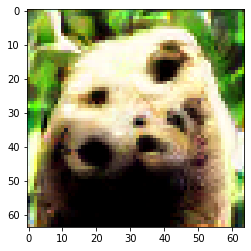

In [ ]:
dec = model.decode(sample_quant)
dec.size()
dec_image = dec.permute([0, 2, 3, 1]).detach().cpu().numpy()
dec_image = ((dec_image + 1) * 127.5).astype(int).reshape([img_size, img_size, 3])
plt.imshow(dec_image)

In [ ]:
base_out_dir = './outs'
for i in range(n_split):
    out_path = os.path.join(base_out_dir, f'output{img_size}_{i:02d}.tsv')
    print(i, out_path)
    encode_dataset(datasets[i], batch_size, out_path)

NameError: ignored

In [ ]:
!nvidia-smi

Sat Jun  4 17:57:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |   9762MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------